In [1]:
import torch
from torch.nn import Module, ModuleList, Sequential
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import EdgeConv, DenseGCNConv, DenseGraphConv, GCNConv, GATConv
from torch_geometric.data import Data

## Distances Calculation

In [2]:
#Euclidean distance
def pairwise_euclidean_distances(x, dim=-1):
    dist = torch.cdist(x,x)**2
    return dist, x

# #Poincarè disk distance r=1 (Hyperbolic)
def pairwise_poincare_distances(x, dim=-1):
    x_norm = (x**2).sum(dim,keepdim=True)
    x_norm = (x_norm.sqrt()-1).relu() + 1 
    x = x/(x_norm*(1+1e-2))
    x_norm = (x**2).sum(dim,keepdim=True)
    
    pq = torch.cdist(x,x)**2
    dist = torch.arccosh(1e-6+1+2*pq/((1-x_norm)*(1-x_norm.transpose(-1,-2))))**2
    return dist, x

In [3]:
def sparse_eye(size):
    """
    Returns the identity matrix as a sparse matrix
    """
    indices = torch.arange(0, size).long().unsqueeze(0).expand(2, size)
    values = torch.tensor(1.0).float().expand(size)
    cls = getattr(torch.sparse, values.type().split(".")[-1])
    return cls(indices, values, torch.Size([size, size])) 

## Layers

In [4]:
class DGM_c(nn.Module):
    input_dim = 4
    debug=False
    
    def __init__(self, embed_f, k=None, distance="euclidean"):
        super(DGM_c, self).__init__()
        self.temperature = nn.Parameter(torch.tensor(1).float())
        self.threshold = nn.Parameter(torch.tensor(0.5).float())
        self.embed_f = embed_f
        self.centroid=None
        self.scale=None
        self.distance = distance
        
        self.scale = nn.Parameter(torch.tensor(-1).float(),requires_grad=False)
        self.centroid = nn.Parameter(torch.zeros((1,1,DGM_c.input_dim)).float(),requires_grad=False)
        
        
    def forward(self, x, A, not_used=None, fixedges=None):
        
        x = self.embed_f(x,A)  
        
        # estimate normalization parameters
        if self.scale <0:            
            self.centroid.data = x.mean(-2,keepdim=True).detach()
            self.scale.data = (0.9/(x-self.centroid).abs().max()).detach()
        
        if self.distance=="hyperbolic":
            D, _x = pairwise_poincare_distances((x-self.centroid)*self.scale)
        else:
            D, _x = pairwise_euclidean_distances((x-self.centroid)*self.scale)
            
        A = torch.sigmoid(self.temperature*(self.threshold.abs()-D))
        
        if DGM_c.debug:
            self.A = A.data.cpu()
            self._x = _x.data.cpu()
            
#         self.A=A
#         A = A/A.sum(-1,keepdim=True)
        return x, A, None

In [5]:
class EdgeG(nn.Module):
    def __init__(self, embed_f, k=5, distance=pairwise_euclidean_distances, sparse=True):
        super(EdgeG, self).__init__()
        
        self.sparse=sparse
        
        self.temperature = nn.Parameter(torch.tensor(4.).float())
        self.embed_f = embed_f
        self.centroid=None
        self.scale=None
        self.k = k
        
        self.debug=False
        if distance == 'euclidean':
            self.distance = pairwise_euclidean_distances
        else:
            self.distance = pairwise_poincare_distances
        
    def forward(self, x, not_used=None, fixedges=None):
        x = self.embed_f(x)  
        
        if self.training:
            if fixedges is not None:                
                return x, fixedges, torch.zeros(fixedges.shape[0],fixedges.shape[-1]//self.k,self.k,dtype=torch.float,device=x.device)
            
            D, _x = self.distance(x)
           
            #sampling here
            edges_hat, logprobs = self.sample_without_replacement(D[None, ...])
                
        else:
            with torch.no_grad():
                if fixedges is not None:                
                    return x, fixedges, torch.zeros(fixedges.shape[0],fixedges.shape[-1]//self.k,self.k,dtype=torch.float,device=x.device)
                D, _x = self.distance(x)

                #sampling here
                edges_hat, logprobs = self.sample_without_replacement(D[None, ...])

              
        if self.debug:
            self.D = D
            self.edges_hat=edges_hat
            self.logprobs=logprobs
            self.x=x

        return x, edges_hat, logprobs
    

    def sample_without_replacement(self, logits):
        b,n,_ = logits.shape
        logits = logits * torch.exp(torch.clamp(self.temperature,-5,5))
        
        q = torch.rand_like(logits) + 1e-8
        lq = (logits-torch.log(-torch.log(q)))
        logprobs, indices = torch.topk(-lq,self.k)  
    
        rows = torch.arange(n).view(1,n,1).to(logits.device).repeat(b,1,self.k)
        edges = torch.stack((indices.view(b,-1),rows.view(b,-1)),-2)
        
        if self.sparse:
            return (edges+(torch.arange(b).to(logits.device)*n)[:,None,None]).transpose(0,1).reshape(2,-1), logprobs
        return edges, logprobs

In [6]:
num_gaussians=32
class LeftTruncatedGaussianMixtureLayer(nn.Module):
    def __init__(self, input_dim, num_gaussians=32):
        super(LeftTruncatedGaussianMixtureLayer, self).__init__()
        #这里的输出维度是num_gaussians * 3，因为对于每个高斯分布，我们需要学习三个参数：权重、均值和标准差
        self.linear = nn.Linear(input_dim, num_gaussians * 3)
        self.input_dim = input_dim
        self.num_gaussians = num_gaussians

    def forward(self, x):
        #params = self.linear(x): 使用线性层计算高斯混合模型的参数。
        params = self.linear(x)
        # 定义一个列表，表示在下一步中将参数张量拆分为权重、均值和标准差时所需的大小
        split_sizes = [self.num_gaussians, self.num_gaussians, self.num_gaussians]
        #将参数张量拆分为权重、均值和标准差三部分
        weights, means, stds = torch.split(params, split_sizes, dim=1)
        
        weights = torch.softmax(weights, dim=1)
        means = torch.clamp(means, min=0)  # 左截断高斯分布
        stds = torch.clamp(stds, min=-709, max=709)
        stds = torch.abs(torch.exp(stds))
        
        # 随机生成样本以近似高斯混合分布
        #print('stds[:, 0].unsqueeze(1):',stds[:, 0].unsqueeze(1))
        z_list = [torch.normal(means[:, i].unsqueeze(1), stds[:, i].unsqueeze(1)) for i in range(self.num_gaussians)]
        z = torch.cat(z_list, dim=1)
        
        z = torch.sum(z * weights.unsqueeze(0), dim=0)
        return z

In [7]:
toy_v=torch.randn(5,10000)
ltgm=LeftTruncatedGaussianMixtureLayer(input_dim=10000, num_gaussians=20)
ltgm(toy_v).shape

torch.Size([5, 20])

In [514]:
'''
class MLP(nn.Module): 
    def __init__(self,x,projection_dim=32,final_activation=False, dropout=0.2):
        super(MLP, self).__init__()
        self.x=x
        #self.x = torch.tensor(self.x, dtype=torch.float32)
        self.projection_dim=projection_dim
        layers_size=[self.x.shape[-1],projection_dim,self.x.shape[-1]]
        layers = []
        #layers.append(LeftTruncatedGaussianMixtureLayer(self.x.shape[-1],projection_dim))
        for li in range(1,len(layers_size)):
            if dropout>0:
                layers.append(nn.Dropout(dropout))
            layers.append(nn.Linear(layers_size[li-1],layers_size[li]))
            if li==len(layers_size)-1 and not final_activation:
                continue
            layers.append(nn.LeakyReLU(0.1))
            
            
        self.MLP = nn.Sequential(*layers)
        
    def forward(self, e=None):
        x_imp=self.x
        x_imp = self.MLP(x_imp)
        return x_imp
'''
class MLP(nn.Module): 
    def __init__(self, x, projection_dim=32, final_activation=False, dropout=0.2):
        super(MLP, self).__init__()
        self.x = x
        self.projection_dim = projection_dim
        layers_size = [self.x.shape[-1], projection_dim, self.x.shape[-1]]
        layers = []

        for li in range(1, len(layers_size)):
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            layers.append(nn.Linear(layers_size[li-1], layers_size[li]))
            if li == len(layers_size) - 1 and not final_activation:
                continue
            layers.append(nn.LeakyReLU(0.1))
            
        self.MLP = nn.Sequential(*layers)
        self.bottleneck_output = None
        
    def forward(self, e=None):
        x_imp = self.x
        self.bottleneck_output = self.MLP[:3](x_imp)  # Assuming the bottleneck layer is the middle linear layer
        x_imp = self.MLP(x_imp)
        return x_imp,self.bottleneck_output

In [ ]:
toy_x=torch.randn(100,1000)


In [513]:
toy_mx=torch.randn(100,10000)
mlp=MLP(toy_mx)
x_imp,bottleneck_output=mlp(toy_mx)
import pandas as pd
pd.DataFrame(bottleneck_output.detach().numpy())

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.910931,-0.008307,-0.090854,0.082123,0.729842,0.128003,-0.104835,-0.086937,1.332742,0.595430,...,-0.007738,-0.040172,0.497406,0.700304,-0.011372,-0.101404,0.230501,0.314670,1.243787,-0.083420
1,0.750871,0.307159,0.232535,0.038515,-0.054340,0.004197,0.674694,0.336512,-0.005580,-0.096065,...,-0.021066,0.114296,-0.032740,-0.024523,-0.097848,0.870241,-0.052250,0.624794,0.426356,0.920642
2,-0.076642,-0.092928,1.868083,-0.026867,0.892989,0.240661,-0.089292,1.018526,0.156084,0.504859,...,-0.019193,-0.038252,-0.011918,-0.027166,0.298781,-0.049203,0.825491,0.444732,0.045274,-0.009409
3,0.102839,-0.005924,0.222096,-0.057937,-0.077856,-0.036565,0.464015,-0.027807,2.107994,-0.070733,...,-0.092847,-0.000340,0.734612,0.383578,0.489764,-0.059298,-0.059822,-0.004846,0.190453,0.264187
4,-0.075176,-0.001919,-0.047225,-0.013296,-0.034376,-0.058630,-0.099342,0.112872,-0.023288,0.086801,...,0.100288,1.063487,-0.027744,-0.099278,-0.014246,0.074943,0.363235,-0.023107,0.234354,1.275707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.049346,0.405594,-0.014733,0.491567,0.610387,-0.003459,0.174253,-0.018890,-0.082758,-0.001573,...,0.823659,-0.002319,0.344188,1.037047,-0.066620,-0.054789,-0.002089,-0.179491,-0.014250,0.067474
96,1.072919,-0.024710,-0.037519,1.479105,-0.031611,0.832385,-0.012761,-0.028149,0.517755,-0.004225,...,0.816588,-0.019064,-0.066910,0.550537,1.512072,-0.046848,0.049188,0.523939,-0.131518,0.530673
97,-0.019167,-0.066794,-0.074343,0.366043,0.155396,-0.003849,0.489006,-0.062182,-0.047586,-0.087389,...,-0.054582,-0.041408,0.630227,-0.041195,-0.137406,-0.112045,0.200652,-0.053890,1.095483,-0.040960
98,-0.083535,-0.057242,-0.064023,0.023094,-0.017024,0.069977,0.646812,-0.014854,0.469799,0.439198,...,-0.043340,0.483240,-0.040058,-0.038779,0.795745,-0.099388,0.564398,0.195131,-0.034878,-0.035757


In [400]:
class DistanceLearningLayer(nn.Module):
    def __init__(self, temperature=4.0, operator='euclidean'):
        super(DistanceLearningLayer, self).__init__()
        self.temperature = temperature
        #self.feature_extractor = nn.Linear(input_dim, output_dim)
        if operator=='euclidean':
            self.distance = pairwise_euclidean_distances
        else:
            self.distance = pairwise_poincare_distances
            

    def forward(self, x):
        # Compute the transformed feature vectors
        #x_transformed = self.feature_extractor(x)

        # Compute pairwise Euclidean distances of transformed feature vectors
        
        #dist, _ = pairwise_euclidean_distances(x)
        dist, _ = self.distance(x)

        # Compute the distance metric based on the formula
        p_ij = torch.exp(-self.temperature * dist)

        return p_ij

In [417]:
'''
class SparseTopKLayer(nn.Module):
    def __init__(self, k=5, temperature=1.0):
        super(SparseTopKLayer, self).__init__()
        self.k = k
        self.temperature = nn.Parameter(torch.tensor(temperature).float(), requires_grad=False)

    def forward(self, matrix):
        n = matrix.size(0)

        if self.training:
            top_k_logits, top_k_indices = torch.topk(matrix, self.k, dim=-1)
            mask = torch.zeros_like(matrix).scatter_(-1, top_k_indices, 1)
            sparse_matrix = self.gumbel_softmax(matrix * mask)
        else:
            with torch.no_grad():
                top_k_logits, top_k_indices = torch.topk(matrix, self.k, dim=-1)
                mask = torch.zeros_like(matrix).scatter_(-1, top_k_indices, 1)
                sparse_matrix = self.gumbel_softmax(matrix * mask)

        edge_index_row, edge_index_col = torch.nonzero(mask, as_tuple=True)
        edge_index = torch.stack((edge_index_row, edge_index_col), dim=0).to(torch.long)
        return sparse_matrix, edge_index

    def gumbel_softmax(self, logits):
        gumbels = -torch.empty_like(logits).exponential_().log()
        gumbels = (logits + gumbels) / self.temperature
        return F.softmax(gumbels, dim=-1)
'''
'''
class SparseTopKLayer(nn.Module):
    def __init__(self, k=5, temperature=1.0):
        super(SparseTopKLayer, self).__init__()
        self.k = k
        self.temperature = nn.Parameter(torch.tensor(temperature).float(), requires_grad=False)

    def forward(self, matrix):
        n = matrix.size(0)

        if self.training:
            top_k_logits, top_k_indices = torch.topk(matrix, self.k, dim=-1)
            #print('tok k logits: ',top_k_logits.shape)
            #print('tok k indices: ',top_k_indices.shape)
            mask = torch.zeros_like(matrix).scatter_(-1, top_k_indices, 1)
            #print('mask: ',mask.shape)
            gumbel_matrix = self.gumbel_softmax(matrix * mask)
            top_k_logits, top_k_indices = torch.topk(gumbel_matrix, self.k, dim=-1)
            sparse_matrix = torch.zeros_like(matrix).scatter_(-1, top_k_indices, 1)
        else:
            with torch.no_grad():
                top_k_logits, top_k_indices = torch.topk(matrix, self.k, dim=-1)
                mask = torch.zeros_like(matrix).scatter_(-1, top_k_indices, 1)
                gumbel_matrix = self.gumbel_softmax(matrix * mask)
                top_k_logits, top_k_indices = torch.topk(gumbel_matrix, self.k, dim=-1)
                sparse_matrix = torch.zeros_like(matrix).scatter_(-1, top_k_indices, 1)
        # Binarize sparse_matrix using the mask
        #sparse_matrix = mask.float()

        # Get edge_index directly from sparse_matrix
        edge_index_row, edge_index_col = torch.nonzero(sparse_matrix, as_tuple=True)
        edge_index = torch.stack((edge_index_row, edge_index_col), dim=0).to(torch.long)

        return sparse_matrix, edge_index

    def gumbel_softmax(self, logits):
        gumbels = -torch.empty_like(logits).exponential_().log()
        gumbels = (logits + gumbels) / self.temperature
        return F.softmax(gumbels, dim=-1)
'''
class SparseTopKLayer(nn.Module):
    def __init__(self, k=5, temperature=4.0):
        super(SparseTopKLayer, self).__init__()
        self.k = k
        self.temperature = nn.Parameter(torch.tensor(temperature).float(), requires_grad=True)

    def forward(self, matrix):
        n = matrix.size(0)

        if self.training:
            top_k_logits, top_k_indices = torch.topk(matrix, self.k, dim=-1)
            mask = torch.zeros_like(matrix).scatter_(-1, top_k_indices, 1)
            sparse_matrix = self.gumbel_softmax(matrix * mask)
        else:
            with torch.no_grad():
                top_k_logits, top_k_indices = torch.topk(matrix, self.k, dim=-1)
                mask = torch.zeros_like(matrix).scatter_(-1, top_k_indices, 1)
                sparse_matrix = self.gumbel_softmax(matrix * mask)

        edge_index_row, edge_index_col = torch.nonzero(mask, as_tuple=True)
        edge_index = torch.stack((edge_index_row, edge_index_col), dim=0).to(torch.long)
        return sparse_matrix, edge_index

    def gumbel_softmax(self, logits):
        gumbels = -torch.empty_like(logits).exponential_().log()
        gumbels = (logits + gumbels) / self.temperature
        return F.softmax(gumbels, dim=-1)

In [12]:
'''
x=torch.tensor(X, dtype=torch.float32)
distance_layer=DistanceLearningLayer()
matrix=distance_layer(x)
topklayer=SparseTopKLayer(k=5)
sparse_matrix, edge_index=topklayer(matrix)
edge_index
'''

'\nx=torch.tensor(X, dtype=torch.float32)\ndistance_layer=DistanceLearningLayer()\nmatrix=distance_layer(x)\ntopklayer=SparseTopKLayer(k=5)\nsparse_matrix, edge_index=topklayer(matrix)\nedge_index\n'

In [13]:
class Net(torch.nn.Module):
    def __init__(self, x):
        super(Net, self).__init__()
        #self.num_features=x.shape[-1]
        self.conv1 = GCNConv(x.shape[-1], int(x.shape[-1]/64))
        self.conv2 = GCNConv(int(x.shape[-1]/64), x.shape[-1])

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))

        return x

In [14]:
class GraphDiffusionModule(nn.Module):
    def __init__(self, x, num_layers=2):
        super(GraphDiffusionModule, self).__init__()
        
        # 初始化GCN层
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GCNConv(x.shape[-1], int(x.shape[-1]/64)))
        for _ in range(num_layers - 2):
            self.gcn_layers.append(GCNConv(int(x.shape[-1]/64), int(x.shape[-1]/64)))
        self.gcn_layers.append(GCNConv(int(x.shape[-1]/64),x.shape[-1]))

    def forward(self, x, edge_index):
        # 对缺失值进行处理，这里将缺失值设为0
        #x = torch.where(torch.isnan(x), torch.zeros_like(x), x)

        # 将输入数据传递到GCN层
        for gcn_layer in self.gcn_layers[:-1]:
            x = gcn_layer(x, edge_index)
            x = torch.relu(x)
        
        # 最后一层GCN
        x = self.gcn_layers[-1](x, edge_index)
        return x

In [15]:
class Identity(nn.Module):
    def __init__(self,retparam=None):
        self.retparam=retparam
        super(Identity, self).__init__()
        
    def forward(self, *params):
        if self.retparam is not None:
            return params[self.retparam]
        return params

## Models

In [16]:
class ImputeModel(nn.Module):
    def __init__(self,x):
        super(ImputeModel, self).__init__()
        self.embed_f = MLP(x)  # 假设输出的嵌入大小为 64
        self.edgeG = EdgeG(self.embed_f)
        self.net = Net(x)

    def forward(self, x):
        x, edges_hat, logprobs = self.edgeG(x)
        
        # 将 edges_hat 转换为 edge_index 格式
        edge_index = edges_hat.reshape(2, -1).long()

        # 将 x 和 edge_index 作为输入传递给 Net 模块
        output = self.net(x, edge_index)

        return output

In [515]:
class IntegratedModel(nn.Module):
    def __init__(self, x, projection_dim=32, dropout=0.3):
        super(IntegratedModel, self).__init__()
        self.x=x.clone().detach().requires_grad_(True)
        self.mlp = MLP(self.x, projection_dim=projection_dim, dropout=dropout)
        self.distance_learning_layer = DistanceLearningLayer(operator='euclidean')
        self.sparse_topk_layer = SparseTopKLayer(k=5)
        self.net = Net(x)
        self.diffusion=GraphDiffusionModule(x)

    def forward(self, x,impute='GAE'):
        # MLP
        x_imp,bottleneck_output = self.mlp(self.x)
        
        # DistanceLearningLayer
        matrix = self.distance_learning_layer(bottleneck_output)
        
        # SparseTopKLayer
        sparse_matrix, edge_index = self.sparse_topk_layer(matrix)
        
        
        if impute=='GAE':
        # Net (GCN)
            output = self.net(self.x, edge_index)
        
        else:
        # Graph diffusion    
            output=self.diffusion(self.x,edge_index)

        return output

In [516]:
impute_model=IntegratedModel(toy_mx)
sparse_matrix,output=impute_model(toy_mx)
sparse_matrix

ValueError: too many values to unpack (expected 2)

## Data Preprocessing

In [19]:
import numpy as np
import copy
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import networkx as nx
#import scipy.io as io
from scipy.sparse import coo_matrix
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data

In [20]:
import scanpy as sc
import seaborn as sns
import anndata
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [21]:
class MatrixDataset(Dataset):
    def __init__(self, x_data):
        self.x_data = x_data

    def __getitem__(self, index):
        x = self.x_data[index]
        return x

    def __len__(self):
        return len(self.x_data)

In [22]:
def filter_genes(gene_metric, threshold, NN_lim=None):
    
    if not str(NN_lim).isdigit():
        NN_lim = (gene_metric > threshold).sum() #变异系数大于临界值的数量
    
    genes_to_impute = gene_metric.index[:NN_lim]

    print("{} genes were masked for imputation".format(len(genes_to_impute)))

    return genes_to_impute

In [23]:
def mask(data_train, masked_prob):
    index_pair_train = np.where(data_train != 0)
    np.random.seed(seed)
    masking_idx_train = np.random.choice(index_pair_train[0].shape[0], int(index_pair_train[0].shape[0] * masked_prob), replace = False)
    #to retrieve the position of the masked: data_train[index_pair_train[0][masking_idx], index_pair[1][masking_idx]]
    X_train = copy.deepcopy(data_train)
    X_train[index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]] = 0
    return X_train, index_pair_train, masking_idx_train

In [632]:
# number of cells * number of genes
adata = sc.read('./data/neuron1k/matrix.mtx')
adata=adata.T
data = adata.X

In [633]:
data

<1301x31053 sparse matrix of type '<class 'numpy.float32'>'
	with 4220492 stored elements in Compressed Sparse Row format>

In [634]:
masked_prob = min(len(np.where(data.todense() != 0)[0]) / (data.todense().shape[0] * data.todense().shape[1]), 0.3)
print(masked_prob)

0.10446774529663438

In [635]:
len(np.where(data.todense() != 0)[0]) / (data.todense().shape[0] * data.todense().shape[1])

0.10446774529663438

In [27]:
raw = pd.DataFrame(data.todense())

In [28]:
raw

,0,1,2,3,4,5,6,7,8,9,...,31043,31044,31045,31046,31047,31048,31049,31050,31051,31052
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1299,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0


In [29]:
gene_metric = (raw.var()/(1+raw.mean())).sort_values(ascending=False) #var()计算方差,变异系数
gene_metric = gene_metric[gene_metric != 0] #筛选出变异系数非0的基因

genes_to_impute = filter_genes(gene_metric, 0.5)

4515 genes were masked for imputation


In [30]:
genes_to_impute

Int64Index([13666, 13665, 21029, 21031, 14942, 30388,  5172, 15264, 26448,
            26845,
            ...
             1598, 25738, 10724,  7546,  6114, 12267, 27025, 30105, 16028,
            30089],
           dtype='int64', length=4515)

In [31]:
data=data.tocsr()[:, genes_to_impute]

In [32]:
data

<1301x4515 sparse matrix of type '<class 'numpy.float32'>'
	with 2737949 stored elements in Compressed Sparse Row format>

In [33]:
# normalize cell counts
rowsum = np.sum(data, axis = 1)
norm_transcript = np.median(np.asarray(rowsum))

In [34]:
data_norm = (data/rowsum.reshape(-1,1))*norm_transcript

In [35]:
data_norm

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.3496    ],
        [1.0522704 , 0.        , 0.        , ..., 2.1045408 , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.36576903, 0.        , 0.        , ..., 0.73153806, 0.36576903,
         0.36576903],
        [0.        , 0.        , 0.        , ..., 2.9036145 , 0.        ,
         2.9036145 ]], dtype=float32)

In [36]:
adata_new=anndata.AnnData(X=data_norm, obs=adata.obs, var=adata.var.iloc[genes_to_impute])

In [37]:
adata_new

AnnData object with n_obs × n_vars = 1301 × 4515

#### KS test

In [266]:
from scipy import stats

In [267]:
# Initialize lists to store test results for each gene
ks_poisson_results = []
ks_neg_binomial_results = []

In [269]:
# Test the distribution of each gene separately
for gene_expression in adata_new.X.T:
    # Fit a gamma distribution to the gene expression data
    gamma_params = stats.gamma.fit(gene_expression)

    # Test against the Poisson distribution using the mean of the gamma distribution as λ
    poisson_lambda = gamma_params[0] * gamma_params[2]
    ks_poisson = stats.kstest(gene_expression, 'poisson', args=(poisson_lambda,))
    ks_poisson_results.append(ks_poisson)

    # Test against the negative binomial distribution using the mean of the gamma distribution as the success probability (p)
    neg_binomial_r = gamma_params[0]
    neg_binomial_p = 1 / (1 + gamma_params[2])
    ks_neg_binomial = stats.kstest(gene_expression, 'nbinom', args=(neg_binomial_r, neg_binomial_p))
    ks_neg_binomial_results.append(ks_neg_binomial)

# Analyze the overall distribution trends across all genes
print("KS test results for Poisson (mean):", np.mean(ks_poisson_results, axis=0))
print("KS test results for Negative Binomial (mean):", np.mean(ks_neg_binomial_results, axis=0))

KS test results for Poisson (mean): [6.52527868e-01 4.67843440e-30]

KS test results for Negative Binomial (mean): [7.48837611e-01 6.13055077e-16]

#### TSNE

In [219]:
sc.tl.pca(adata_new, svd_solver='arpack')

In [220]:
# Compute the neighborhood graph
sc.pp.neighbors(adata_new, n_neighbors=5, n_pcs=50)

In [221]:
adata_new.obsm

AxisArrays with keys: X_pca

D:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\Anaconda3\envs\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


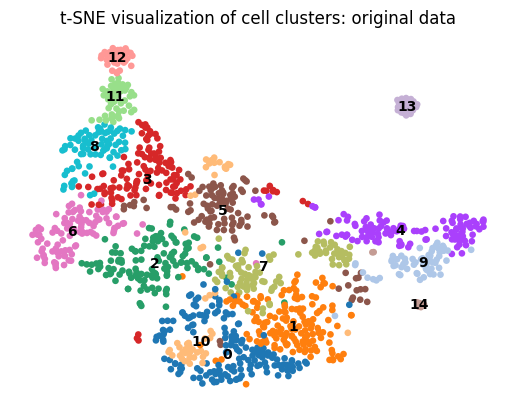

In [222]:
# Perform Leiden clustering
sc.tl.leiden(adata_new, resolution=0.6)

# Run t-SNE and visualize the results
tsne = TSNE(n_components=2, random_state=42)
adata_new.obsm['X_tsne'] = tsne.fit_transform(adata_new.X)
sc.pl.tsne(adata_new, color='leiden', legend_loc='on data', title='t-SNE visualization of cell clusters: original data', frameon=False)

In [613]:
seed = 6
split = [0.9, 0.05, 0.05]
np.random.seed(seed)

In [614]:
test_val = np.random.choice(data_norm.shape[0], int(data_norm.shape[0] * (split[1] + split[2])), replace = False)
train = [i for i in list(range(data_norm.shape[0])) if i not in test_val]
np.random.seed(seed)
test = np.random.choice(test_val, int(len(test_val) * (split[2] / (split[1] + split[2]))), replace = False)
val = [i for i in test_val if i not in test]

In [615]:
data_train = data_norm[train]
data_val = data_norm[val]
data_test = data_norm[test]

In [616]:
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(1171, 4515)

(65, 4515)

(65, 4515)

In [617]:
X_train, index_pair_train, masking_idx_train = mask(data_train, masked_prob)
X_val, index_pair_val, masking_idx_val = mask(data_val, masked_prob)
X_test, index_pair_test, masking_idx_test = mask(data_test, masked_prob)

In [618]:
X_norm, _, _ = mask(data_norm, masked_prob)

In [619]:
X = np.vstack((X_train, X_val, X_test))

#### PCA and KNN for cell topology generation

In [230]:
pca = PCA(n_components=50)
data_pca = pca.fit_transform(X)
print(sum(pca.explained_variance_ratio_)) 

D:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.9859424231981393

In [231]:
k = 5
A = kneighbors_graph(data_pca, k, mode='connectivity', include_self=False)
G = nx.from_numpy_array(A.todense())

In [232]:
# prepare for pytorch geometric data loading
edges = []
for (u, v) in G.edges():
    edges.append([u, v])
    edges.append([v, u])

edges = np.array(edges).T
print(edges.shape)

(2, 10112)

In [233]:
edges = torch.tensor(edges, dtype = torch.long)

feat = torch.tensor(X, dtype=torch.float)
G_data = Data(x=feat, edge_index=edges)

In [234]:
# 添加节点
G.add_nodes_from(range(feat.cpu().numpy().shape[0]))

# 添加边
edge_set = [(edges.cpu().numpy()[0, i], edges.cpu().numpy()[1, i]) for i in range(edges.cpu().numpy().shape[1])]
G.add_edges_from(edge_set)

In [235]:
G

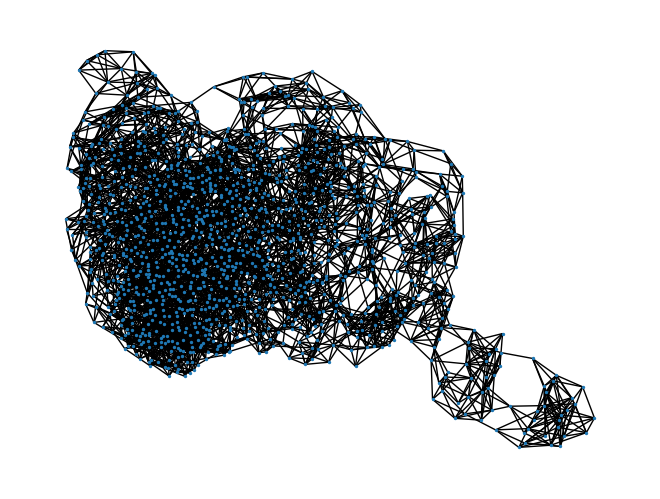

In [236]:
pos = nx.kamada_kawai_layout(G)  # 使用spring布局算法
nx.draw(G, pos, with_labels=False, node_size=2, font_size=3)
plt.show()

selected nodes: 
[
    0,
    2,
    4,
    6,
    8,
    10,
    12,
    14,
    16,
    18,
    20,
    22,
    24,
    26,
    28,
    30,
    32,
    34,
    36,
    38,
    40,
    42,
    44,
    46,
    48,
    50,
    52,
    54,
    56,
    58,
    60,
    62,
    64,
    66,
    68,
    70,
    72,
    74,
    76,
    78,
    80,
    82,
    84,
    86,
    88,
    90,
    92,
    94,
    96,
    98,
    100,
    102,
    104,
    106,
    108,
    110,
    112,
    114,
    116,
    118,
    120,
    122,
    124,
    126,
    128,
    130,
    132,
    134,
    136,
    138,
    140,
    142,
    144,
    146,
    148,
    150,
    152,
    154,
    156,
    158,
    160,
    162,
    164,
    166,
    168,
    170,
    172,
    174,
    176,
    178,
    180,
    182,
    184,
    186,
    188,
    190,
    192,
    194,
    196,
    198,
    200,
    202,
    204,
    206,
    208,
    210,
    212,
    214,
    216,
    218,
    220,
    222,
    224,
    226,
    228,
    230,
    232,
    234,
    236,
    238,
    240,
    242,
    244,
    246,
    248,
    250,
    252,
    254,
    256,
    258,
    260,
    262,
    264,
    266,
    268,
    270,
    272,
    274,
    276,
    278,
    280,
    282,
    284,
    286,
    288,
    290,
    292,
    294,
    296,
    298,
    300,
    302,
    304,
    306,
    308,
    310,
    312,
    314,
    316,
    318,
    320,
    322,
    324,
    326,
    328,
    330,
    332,
    334,
    336,
    338,
    340,
    342,
    344,
    346,
    348,
    350,
    352,
    354,
    356,
    358,
    360,
    362,
    364,
    366,
    368,
    370,
    372,
    374,
    376,
    378,
    380,
    382,
    384,
    386,
    388,
    390,
    392,
    394,
    396,
    398,
    400,
    402,
    404,
    406,
    408,
    410,
    412,
    414,
    416,
    418,
    420,
    422,
    424,
    426,
    428,
    430,
    432,
    434,
    436,
    438,
    440,
    442,
    444,
    446,
    448,
    450,
    452,
    454,
    456,
    458,
    460,
    462,
    464,
    466,
    468,
    470,
    472,
    474,
    476,
    478,
    480,
    482,
    484,
    486,
    488,
    490,
    492,
    494,
    496,
    498,
    500,
    502,
    504,
    506,
    508,
    510,
    512,
    514,
    516,
    518,
    520,
    522,
    524,
    526,
    528,
    530,
    532,
    534,
    536,
    538,
    540,
    542,
    544,
    546,
    548,
    550,
    552,
    554,
    556,
    558,
    560,
    562,
    564,
    566,
    568,
    570,
    572,
    574,
    576,
    578,
    580,
    582,
    584,
    586,
    588,
    590,
    592,
    594,
    596,
    598,
    600,
    602,
    604,
    606,
    608,
    610,
    612,
    614,
    616,
    618,
    620,
    622,
    624,
    626,
    628,
    630,
    632,
    634,
    636,
    638,
    640,
    642,
    644,
    646,
    648,
    650,
    652,
    654,
    656,
    658,
    660,
    662,
    664,
    666,
    668,
    670,
    672,
    674,
    676,
    678,
    680,
    682,
    684,
    686,
    688,
    690,
    692,
    694,
    696,
    698,
    700,
    702,
    704,
    706,
    708,
    710,
    712,
    714,
    716,
    718,
    720,
    722,
    724,
    726,
    728,
    730,
    732,
    734,
    736,
    738,
    740,
    742,
    744,
    746,
    748,
    750,
    752,
    754,
    756,
    758,
    760,
    762,
    764,
    766,
    768,
    770,
    772,
    774,
    776,
    778,
    780,
    782,
    784,
    786,
    788,
    790,
    792,
    794,
    796,
    798,
    800,
    802,
    804,
    806,
    808,
    810,
    812,
    814,
    816,
    818,
    820,
    822,
    824,
    826,
    828,
    830,
    832,
    834,
    836,
    838,
    840,
    842,
    844,
    846,
    848,
    850,
    852,
    854,
    856,
    858,
    860,
    862,
    864,
    866,
    868,
    870,
    872,
    874,
    876,
    878,
    880,
    882,
    884,
    886,
    888,
    890,
    892,
    894,
    

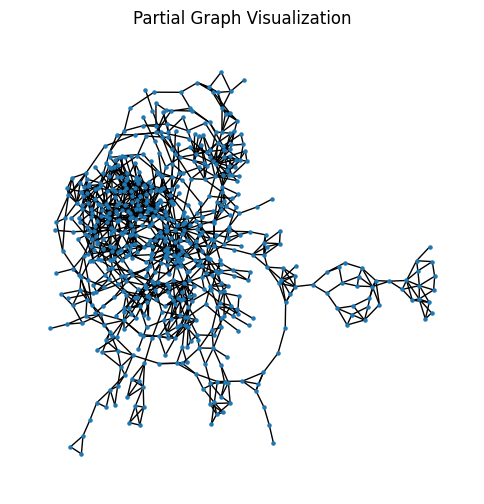

In [237]:
# 选择要显示的节点
#selected_nodes = list(range(100))  # 仅显示前100个节点
selected_nodes = list(range(0, G.number_of_nodes(), 2))  # 每隔两个节点选一个
print('selected nodes: ',selected_nodes)
subgraph = G.subgraph(selected_nodes)

# 使用布局算法计算节点位置
pos = nx.kamada_kawai_layout(subgraph)

# 绘制子图
plt.figure(figsize=(6, 6))
plt.title("Partial Graph Visualization")
nx.draw(subgraph, pos, node_size=5, font_size=8)
plt.show()

## Training

In [45]:
from pathlib import Path

from scipy.stats import pearsonr
import torch
import torch.nn as nn
import torch.optim as optim

from rich import print

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
import torch
import torch.nn.functional as F
from torch import nn
from scipy.stats import pearsonr

In [267]:
'''
class ImputeLoss(nn.Module):
    def __init__(self, alpha, beta, lambda_, adjacency_matrix):
        super(ImputeLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.lambda_ = lambda_
        self.adjacency_matrix = adjacency_matrix

    def forward(self, y_pred, y_true,index_pair, masking_idx,mode=None):
        if mode=='train':
            # Get the masked values from y_pred
            y_pred_masked = y_pred[:len(train)][index_pair[0][masking_idx], index_pair[1][masking_idx]].to(device)
            y_true_masked = y_true[index_pair[0][masking_idx], index_pair[1][masking_idx]].to(device)
            adjacency_mx=self.adjacency_matrix[:len(train),:len(train)].to(device)
            masked_mx_pred=torch.zeros(y_true.shape).to(device)
            masked_mx_true=torch.zeros(y_true.shape).to(device)
            masked_mx_pred[index_pair[0][masking_idx], index_pair[1][masking_idx]]=y_pred_masked
            masked_mx_true[index_pair[0][masking_idx], index_pair[1][masking_idx]]=y_true_masked
            length=len(train)
        if mode=='val':
            y_pred_masked = y_pred[len(train):(len(train)+len(val))][index_pair[0][masking_idx], index_pair[1][masking_idx]].to(device)
            y_true_masked = y_true[index_pair[0][masking_idx], index_pair[1][masking_idx]].to(device)
            adjacency_mx=self.adjacency_matrix[len(train):(len(train)+len(val)),len(train):(len(train)+len(val))].to(device)
            masked_mx_pred=torch.zeros(y_true.shape).to(device)
            masked_mx_true=torch.zeros(y_true.shape).to(device)
            masked_mx_pred[index_pair[0][masking_idx], index_pair[1][masking_idx]]=y_pred_masked
            masked_mx_true[index_pair[0][masking_idx], index_pair[1][masking_idx]]=y_true_masked
            length=len(val)
        if mode=='test':
            y_pred_masked = y_pred[-len(test):][index_pair[0][masking_idx], index_pair[1][masking_idx]].to(device)
            y_true_masked = y_true[index_pair[0][masking_idx], index_pair[1][masking_idx]].to(device)
            adjacency_mx=self.adjacency_matrix[-len(test):,-len(test):].to(device)
            masked_mx_pred=torch.zeros(y_true.shape).to(device)
            masked_mx_true=torch.zeros(y_true.shape).to(device)
            masked_mx_pred[index_pair[0][masking_idx], index_pair[1][masking_idx]]=y_pred_masked
            masked_mx_true[index_pair[0][masking_idx], index_pair[1][masking_idx]]=y_true_masked
            length=len(test)

        l1_loss = torch.abs(y_true_masked - y_pred_masked).to(device)
        l2_loss = torch.square(y_true_masked - y_pred_masked).to(device)
        weighted_loss = (self.alpha * l1_loss + self.beta * l2_loss).to(device)
        
        # Compute graph regularization using masked y_pred
        #y_pred_masked = y_pred_masked.view(-1, length)
        #print(masked_mx_pred.shape,adjacency_mx.shape)
        #print(torch.matmul(adjacency_mx,masked_mx_pred).shape)
        graph_regularization = torch.abs(torch.matmul(adjacency_mx,masked_mx_pred) - masked_mx_pred).to(device)
        total_loss = (torch.mean(weighted_loss) + self.lambda_ * torch.mean(graph_regularization)).to(device)

        return total_loss
'''
class ImputeLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=1.0):
        super(ImputeLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.relu = nn.ReLU()

    def forward(self, y_pred, y_true):
        # 计算 L1 损失（鼓励稀疏性）
        mse_loss = nn.MSELoss()(y_pred, y_true)
        
        # 计算负值惩罚项
        negative_values = self.relu(-y_pred)
        negative_value_penalty = torch.sum(negative_values)
        
        # 计算总损失
        total_loss = mse_loss + self.alpha * negative_value_penalty + self.gamma * mse_loss
        return total_loss

In [220]:
'''
alpha=0.5
beta=0.5
lambda_=0.1
y_pred=torch.randn(1301,4515)
y_true=torch.tensor(data_train, dtype = torch.float32)
np.random.seed(42)
adjacency_matrix = np.random.randint(0, 2, (1301, 1301))
adjacency_matrix_torch = torch.tensor(adjacency_matrix, dtype=torch.float32)
imp_loss=ImputeLoss(alpha, beta, lambda_, adjacency_matrix_torch)
imp_loss(y_pred, y_true,index_pair_train, masking_idx_train,mode='train')
'''

"\nalpha=0.5\nbeta=0.5\nlambda_=0.1\ny_pred=torch.randn(1301,4515)\ny_true=torch.tensor(data_train, dtype = torch.float32)\nnp.random.seed(42)\nadjacency_matrix = np.random.randint(0, 2, (1301, 1301))\nadjacency_matrix_torch = torch.tensor(adjacency_matrix, dtype=torch.float32)\nimp_loss=ImputeLoss(alpha, beta, lambda_, adjacency_matrix_torch)\nimp_loss(y_pred, y_true,index_pair_train, masking_idx_train,mode='train')\n"

In [620]:
X

matrix([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         1.3496   ],
        [1.0522704, 0.       , 0.       , ..., 2.1045408, 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.4318333, 0.8636666,
         0.8636666],
        [0.       , 0.       , 0.       , ..., 1.6426485, 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32)

In [621]:
x = torch.tensor(X, dtype=torch.float).to(device)
model=IntegratedModel(x).to(device)

In [622]:
model

IntegratedModel(
  (mlp): MLP(
    (MLP): Sequential(
      (0): Dropout(p=0.3, inplace=False)
      (1): Linear(in_features=4515, out_features=32, bias=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=32, out_features=4515, bias=True)
    )
  )
  (distance_learning_layer): DistanceLearningLayer()
  (sparse_topk_layer): SparseTopKLayer()
  (net): Net(
    (conv1): GCNConv(4515, 70)
    (conv2): GCNConv(70, 4515)
  )
  (diffusion): GraphDiffusionModule(
    (gcn_layers): ModuleList(
      (0): GCNConv(4515, 70)
      (1): GCNConv(70, 4515)
    )
  )
)

In [623]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=5e-4)

In [603]:
alpha=1.0
gamma=1.0
sigma = 0.2
theta = 0.8
'''
def train_wrapper(model):
    model.train()
    optimizer.zero_grad()
    adjacency_matrix, pred = model(x)
    dropout_pred = pred[:len(train)][index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]]
    print('pred shape: ',dropout_pred.shape )
    dropout_true = data_train[index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]]

    loss_fn_mlp=nn.MSELoss()
    loss_fn_net = nn.MSELoss()
    loss_mlp = loss_fn_mlp(model.mlp(x)[:len(train)][index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]], 
                           torch.tensor(dropout_true, dtype = torch.float).to(device))
    #print('loss_mlp: ',loss_mlp)
    loss_net = loss_fn_net(dropout_pred, torch.tensor(dropout_true, dtype = torch.float).to(device))
    #print('loss_net: ',loss_net)
    total_loss = sigma*loss_mlp + theta*loss_net
    total_loss.backward()
    optimizer.step()
    loss_train = total_loss

    loss = val_wrapper(model)

    return loss_train.item(), loss
'''
'''
def train_wrapper(model):
    model.train()
    optimizer.zero_grad()
    adjacency_matrix, pred = model(x)
    dropout_pred = pred[:len(train)][index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]]
    #print('pred shape: ',dropout_pred.shape )
    dropout_true = data_train[index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]]

    loss_fn_mlp=nn.MSELoss()
    loss_fn_net = ImputeLoss(alpha, beta, lambda_, adjacency_matrix).to(device)
    loss_mlp = loss_fn_mlp(model.mlp(x)[:len(train)][index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]], 
                           torch.tensor(dropout_true, dtype = torch.float).to(device))
    #print('loss_mlp: ',loss_mlp)
    #loss_net = loss_fn_net(dropout_pred, torch.tensor(dropout_true, dtype = torch.float).to(device))
    loss_net=loss_fn_net(pred,torch.tensor(data_train,dtype=torch.float).to(device),index_pair_train,masking_idx_train,mode='train')
    #print('loss_net: ',loss_net)
    total_loss = sigma*loss_mlp + theta*loss_net
    total_loss.backward()
    optimizer.step()
    loss_train = total_loss

    loss = val_wrapper(model)

    return loss_train.item(), loss
'''
def train_wrapper(model):
    model.train()
    optimizer.zero_grad()
    pred = model(x)
    x_imp,bottleneck=model.mlp(x)
    dropout_pred = pred[:len(train)][index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]]
    #print('pred shape: ',dropout_pred.shape )
    dropout_true = data_train[index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]]

    loss_fn_mlp=nn.MSELoss()
    loss_fn_net = nn.MSELoss()
    loss_mlp = loss_fn_mlp(x_imp[:len(train)][index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]], 
                           torch.tensor(dropout_true, dtype = torch.float).to(device))
    #print('loss_mlp: ',loss_mlp)
    loss_net = loss_fn_net(dropout_pred, torch.tensor(dropout_true, dtype = torch.float).to(device))
    #print('loss_net: ',loss_net)
    total_loss = sigma*loss_mlp + theta*loss_net
    total_loss.backward()
    optimizer.step()
    loss_train = total_loss

    loss = val_wrapper(model)

    return loss_train.item(), loss

In [628]:

'''
def val_wrapper(model):
    model.eval()
    pred, accs = model(x), []
    dropout_pred = pred[len(train):(len(train)+len(val))][index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]]
    dropout_true = data_val[index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]]
    #loss_fct = nn.MSELoss()
    #loss = loss_fct(dropout_pred, torch.tensor(dropout_true, dtype = torch.long).to(device))    
    loss_fn_mlp=nn.MSELoss()
    loss_fn_net = nn.MSELoss()
    loss_mlp = loss_fn_mlp(model.mlp(x)[len(train):(len(train)+len(val))][index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]],
                           torch.tensor(dropout_true, dtype = torch.long).to(device))
    loss_net = loss_fn_net(dropout_pred, torch.tensor(dropout_true, dtype = torch.long).to(device))
    total_loss = alpha*loss_mlp + beta*loss_net
    return total_loss.item()
'''
'''
@torch.no_grad()
def val_wrapper(model):
    model.eval()
    adjacency_matrix,pred = model(x)
    accs = []
    dropout_pred = pred[len(train):(len(train)+len(val))][index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]]
    dropout_true = data_val[index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]]
    #loss_fct = nn.MSELoss()
    #loss = loss_fct(dropout_pred, torch.tensor(dropout_true, dtype = torch.long).to(device))    
    loss_fn_mlp=nn.MSELoss()
    loss_fn_net = ImputeLoss(alpha, beta, lambda_, adjacency_matrix).to(device)
    loss_mlp = loss_fn_mlp(model.mlp(x)[len(train):(len(train)+len(val))][index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]],
                           torch.tensor(dropout_true, dtype = torch.long).to(device))
    loss_net=loss_fn_net(pred,torch.tensor(data_val,dtype=torch.float).to(device),index_pair_val,masking_idx_val,mode='val')
    total_loss = sigma*loss_mlp + theta*loss_net
    return total_loss.item()
'''
@torch.no_grad()
def val_wrapper(model):
    model.eval()
    pred, accs = model(x), []
    x_imp,bottleneck=model.mlp(x)
    dropout_pred = pred[len(train):(len(train)+len(val))][index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]]
    dropout_true = data_val[index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]]
    #loss_fct = nn.MSELoss()
    #loss = loss_fct(dropout_pred, torch.tensor(dropout_true, dtype = torch.long).to(device))    
    loss_fn_mlp=nn.MSELoss()
    loss_fn_net = nn.MSELoss()
    loss_mlp = loss_fn_mlp(x_imp[len(train):(len(train)+len(val))][index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]],
                           torch.tensor(dropout_true, dtype = torch.long).to(device))
    loss_net = loss_fn_net(dropout_pred, torch.tensor(dropout_true, dtype = torch.long).to(device))
    total_loss = sigma*loss_mlp + theta*loss_net
    return total_loss.item()

In [629]:
'''
def test_wrapper(model):
    model.eval()
    pred, accs = model(x), []
    dropout_pred = pred[-len(test):][index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    dropout_true = data_test[index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    loss_fn_mlp=nn.MSELoss()
    loss_fn_net = ImputeLoss(alpha, beta, lambda_, adjacency_matrix).to(device)
    loss_mlp = loss_fn_mlp(model.mlp(x)[-len(test):][index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]],
                           torch.tensor(dropout_true, dtype = torch.long).to(device))
    #print('loss_mlp: ',loss_mlp)
    loss_net = loss_fn_net(dropout_pred, torch.tensor(dropout_true, dtype = torch.long).to(device))
    #print('loss_net: ',loss_net)
    total_loss = alpha*loss_mlp + beta*loss_net 
    return total_loss.item()
'''
'''
@torch.no_grad()
def test_wrapper(model):
    model.eval()
    adjacency_matrix,pred = model(x)
    accs = []
    dropout_pred = pred[-len(test):][index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    dropout_true = data_test[index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    loss_fn_mlp=nn.MSELoss()
    loss_fn_net = ImputeLoss(alpha, beta, lambda_, adjacency_matrix).to(device)
    loss_mlp = loss_fn_mlp(model.mlp(x)[-len(test):][index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]],
                           torch.tensor(dropout_true, dtype = torch.long).to(device))
    #print('loss_mlp: ',loss_mlp)
    loss_net=loss_fn_net(pred,torch.tensor(data_val,dtype=torch.float).to(device),index_pair_test,masking_idx_test,mode='test')
    #print('loss_net: ',loss_net)
    total_loss = sigma*loss_mlp + theta*loss_net 
    return total_loss.item()
'''
@torch.no_grad()
def test_wrapper(model):
    model.eval()
    pred, accs = model(x), []
    x_imp,bottleneck=model.mlp(x)
    dropout_pred = pred[-len(test):][index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    dropout_true = data_test[index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    loss_fn_mlp=nn.MSELoss()
    loss_fn_net = nn.MSELoss()
    loss_mlp = loss_fn_mlp(x_imp[-len(test):][index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]],
                           torch.tensor(dropout_true, dtype = torch.long).to(device))
    #print('loss_mlp: ',loss_mlp)
    loss_net = loss_fn_net(dropout_pred, torch.tensor(dropout_true, dtype = torch.long).to(device))
    #print('loss_net: ',loss_net)
    total_loss = sigma*loss_mlp + theta*loss_net 
    return total_loss.item()

In [606]:
@torch.no_grad()
def predict(model):
    model.eval()
    pred= model(x)
    accs = []
    dropout_pred = pred[-len(test):][index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    dropout_true = data_test[index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    return dropout_pred, dropout_true

In [624]:
%%time
for epoch in range(1, 1001):
    train_loss, val_loss = train_wrapper(model)
    if epoch % 10 == 0:
        print('Epoch: {}, Training Loss {:.4f}, Validation Loss {:.4f}'.format(epoch, train_loss, val_loss))

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 257381])) that is different to the input size (torch.Size([257381])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 14171])) that is different to the input size (torch.Size([14171])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10, Training Loss 474.1483, Validation Loss 459.0909

Epoch: 20, Training Loss 384.0575, Validation Loss 367.5699

Epoch: 30, Training Loss 291.3419, Validation Loss 245.4047

Epoch: 40, Training Loss 232.5316, Validation Loss 160.2035

Epoch: 50, Training Loss 188.7044, Validation Loss 122.0510

Epoch: 60, Training Loss 118.4049, Validation Loss 104.9145

Epoch: 70, Training Loss 102.3724, Validation Loss 98.1503

Epoch: 80, Training Loss 81.8030, Validation Loss 93.7971

Epoch: 90, Training Loss 85.3240, Validation Loss 89.0439

Epoch: 100, Training Loss 64.3564, Validation Loss 90.2063

Epoch: 110, Training Loss 50.8717, Validation Loss 87.8992

Epoch: 120, Training Loss 65.7398, Validation Loss 88.5395

Epoch: 130, Training Loss 40.9462, Validation Loss 89.8812

Epoch: 140, Training Loss 43.5968, Validation Loss 86.1357

Epoch: 150, Training Loss 44.4547, Validation Loss 88.6472

Epoch: 160, Training Loss 42.9186, Validation Loss 90.6366

Epoch: 170, Training Loss 40.7332, Validation Loss 89.3395

Epoch: 180, Training Loss 48.5282, Validation Loss 90.2868

Epoch: 190, Training Loss 47.7657, Validation Loss 87.5032

Epoch: 200, Training Loss 41.1625, Validation Loss 87.5446

Epoch: 210, Training Loss 44.8078, Validation Loss 85.3836

Epoch: 220, Training Loss 36.8032, Validation Loss 85.6188

Epoch: 230, Training Loss 41.1078, Validation Loss 90.8969

Epoch: 240, Training Loss 43.2561, Validation Loss 89.7962

Epoch: 250, Training Loss 38.7761, Validation Loss 85.1300

Epoch: 260, Training Loss 36.2365, Validation Loss 86.1174

Epoch: 270, Training Loss 34.1698, Validation Loss 88.5055

Epoch: 280, Training Loss 31.6456, Validation Loss 85.5023

Epoch: 290, Training Loss 31.3429, Validation Loss 83.5961

Epoch: 300, Training Loss 37.2483, Validation Loss 81.4689

Epoch: 310, Training Loss 40.8045, Validation Loss 86.2916

Epoch: 320, Training Loss 34.5333, Validation Loss 85.0136

Epoch: 330, Training Loss 34.5185, Validation Loss 82.0717

Epoch: 340, Training Loss 41.5149, Validation Loss 83.6976

Epoch: 350, Training Loss 42.1917, Validation Loss 80.8977

Epoch: 360, Training Loss 42.7094, Validation Loss 81.9771

Epoch: 370, Training Loss 49.6874, Validation Loss 83.4764

Epoch: 380, Training Loss 39.9082, Validation Loss 83.9568

Epoch: 390, Training Loss 32.2839, Validation Loss 83.7054

Epoch: 400, Training Loss 34.4476, Validation Loss 84.8396

Epoch: 410, Training Loss 26.9446, Validation Loss 76.9245

Epoch: 420, Training Loss 36.8248, Validation Loss 79.1051

Epoch: 430, Training Loss 37.6252, Validation Loss 78.7211

Epoch: 440, Training Loss 26.4029, Validation Loss 79.5519

Epoch: 450, Training Loss 42.8355, Validation Loss 77.0561

Epoch: 460, Training Loss 29.7734, Validation Loss 76.4416

Epoch: 470, Training Loss 31.7667, Validation Loss 76.9828

Epoch: 480, Training Loss 31.8905, Validation Loss 75.8653

Epoch: 490, Training Loss 35.8294, Validation Loss 77.8273

Epoch: 500, Training Loss 31.7298, Validation Loss 78.0251

Epoch: 510, Training Loss 36.4886, Validation Loss 80.6056

Epoch: 520, Training Loss 28.5596, Validation Loss 82.6306

Epoch: 530, Training Loss 44.0824, Validation Loss 81.0961

Epoch: 540, Training Loss 46.5820, Validation Loss 76.6838

Epoch: 550, Training Loss 27.4829, Validation Loss 75.7353

Epoch: 560, Training Loss 31.5842, Validation Loss 79.6106

Epoch: 570, Training Loss 34.7448, Validation Loss 82.3396

Epoch: 580, Training Loss 51.6003, Validation Loss 75.7689

Epoch: 590, Training Loss 29.4504, Validation Loss 81.9397

Epoch: 600, Training Loss 33.3808, Validation Loss 85.6329

Epoch: 610, Training Loss 31.5658, Validation Loss 79.2741

Epoch: 620, Training Loss 38.2241, Validation Loss 80.9876

Epoch: 630, Training Loss 31.5909, Validation Loss 79.7711

Epoch: 640, Training Loss 28.8549, Validation Loss 78.1807

Epoch: 650, Training Loss 30.0487, Validation Loss 78.1428

Epoch: 660, Training Loss 46.7761, Validation Loss 79.2964

Epoch: 670, Training Loss 34.2602, Validation Loss 78.2515

Epoch: 680, Training Loss 32.2551, Validation Loss 75.8922

Epoch: 690, Training Loss 31.1761, Validation Loss 75.2156

Epoch: 700, Training Loss 31.5835, Validation Loss 73.3270

Epoch: 710, Training Loss 31.7891, Validation Loss 79.1134

Epoch: 720, Training Loss 35.7925, Validation Loss 75.8431

Epoch: 730, Training Loss 36.8183, Validation Loss 82.7368

Epoch: 740, Training Loss 25.4512, Validation Loss 80.7448

Epoch: 750, Training Loss 41.0859, Validation Loss 79.0457

Epoch: 760, Training Loss 31.6451, Validation Loss 74.8747

Epoch: 770, Training Loss 40.0304, Validation Loss 82.3290

Epoch: 780, Training Loss 37.4890, Validation Loss 76.4399

Epoch: 790, Training Loss 28.2554, Validation Loss 76.9543

Epoch: 800, Training Loss 39.0969, Validation Loss 80.3449

Epoch: 810, Training Loss 27.2937, Validation Loss 78.3896

Epoch: 820, Training Loss 24.4124, Validation Loss 81.0166

Epoch: 830, Training Loss 35.9940, Validation Loss 81.1661

Epoch: 840, Training Loss 34.9753, Validation Loss 78.3641

Epoch: 850, Training Loss 27.0897, Validation Loss 78.9800

Epoch: 860, Training Loss 30.3945, Validation Loss 78.3866

Epoch: 870, Training Loss 39.1040, Validation Loss 80.4771

Epoch: 880, Training Loss 37.1294, Validation Loss 79.0939

Epoch: 890, Training Loss 38.2303, Validation Loss 78.7020

Epoch: 900, Training Loss 28.3051, Validation Loss 81.2295

Epoch: 910, Training Loss 33.8280, Validation Loss 78.4333

Epoch: 920, Training Loss 28.3205, Validation Loss 79.4518

Epoch: 930, Training Loss 25.6072, Validation Loss 83.7630

Epoch: 940, Training Loss 23.0354, Validation Loss 79.5306

Epoch: 950, Training Loss 31.3063, Validation Loss 77.5503

Epoch: 960, Training Loss 25.0889, Validation Loss 76.6527

Epoch: 970, Training Loss 40.6939, Validation Loss 77.1014

Epoch: 980, Training Loss 26.7557, Validation Loss 82.9204

Epoch: 990, Training Loss 31.2401, Validation Loss 77.9445

Epoch: 1000, Training Loss 32.3551, Validation Loss 75.4545

CPU times: total: 5min 39s
Wall time: 58.7 s


In [625]:
loss_test = test_wrapper(model)
print('Testing Loss{:.4f} '.format(loss_test))

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 14473])) that is different to the input size (torch.Size([14473])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Testing Loss639.1346

In [626]:
dropout_pred, dropout_true = predict(model)

print(pearsonr(dropout_pred.cpu().numpy(), np.asarray(dropout_true).reshape(-1,)))

PearsonRResult(statistic=0.9881777664449006, pvalue=0.0)

In [610]:
pearsonr(dropout_pred.cpu().numpy(), np.asarray(dropout_true).reshape(-1,)).statistic

0.9433206168659064

In [627]:
%%time
sigma = 0.2
theta = 0.8
pea_list=[]
for exp in range(0,10):
    x = torch.tensor(X, dtype=torch.float).to(device)
    model=IntegratedModel(x).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=5e-4)
    for epoch in range(1, 1001):
        train_loss, val_loss = train_wrapper(model)
    dropout_pred, dropout_true = predict(model)
    
    print(pearsonr(dropout_pred.cpu().numpy(), np.asarray(dropout_true).reshape(-1,)).statistic)
    pea_list.append(pearsonr(dropout_pred.cpu().numpy(), np.asarray(dropout_true).reshape(-1,)).statistic)
print('mean pearsonr: ', np.mean(pea_list))

0.9835815536779272

0.9886102031521389

0.9786309317338346

0.9853741093845827

0.9899630887792659

0.9849804002970285

0.9873917185591542

0.9843722464442307

0.9805120940885762

0.991946913762999

mean pearsonr:  0.9855363259879738

CPU times: total: 53min 55s
Wall time: 9min 17s


#### TSNE on imputed data (only the zero values)

In [300]:
@torch.no_grad()
def impute_zeros(model,X):
    model.eval()
    index_zero=np.where(X==0)
    pred, accs = model(x), []
    X_imputed=X
    X_imputed[index_zero]=pred[index_zero].cpu().numpy()
    #dropout_pred_train = pred[:len(train)][index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]]
    #dropout_pred_val=pred[len(train):(len(train)+len(val))][index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]]
    #dropout_pred_test=pred[-len(test):][index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    #return dropout_pred_train,dropout_pred_val,dropout_pred_test
    return X_imputed
'''
dropout_pred_train,dropout_pred_val,dropout_pred_test=imputation_results(model)

X_train[index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]] =dropout_pred_train.cpu().numpy()
X_val[index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]] =dropout_pred_val.cpu().numpy()
X_test[index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]=dropout_pred_test.cpu().numpy()

X_imputed=np.vstack((X_train, X_val, X_test))

X_imputed.shape

adata_imp=anndata.AnnData(X=X_imputed, obs=adata.obs, var=adata.var.iloc[genes_to_impute])

sc.tl.pca(adata_imp, svd_solver='arpack')

# Compute the neighborhood graph
sc.pp.neighbors(adata_imp, n_neighbors=10, n_pcs=50)

# Perform Leiden clustering
sc.tl.leiden(adata_imp, resolution=0.3)

# Run t-SNE and visualize the results
tsne = TSNE(n_components=2, random_state=42)
adata_imp.obsm['X_tsne'] = tsne.fit_transform(adata_imp.X)
sc.pl.tsne(adata_imp, color='leiden', legend_loc='on data', title='t-SNE visualization of cell clusters: imputed data', frameon=False)
'''

"\ndropout_pred_train,dropout_pred_val,dropout_pred_test=imputation_results(model)\n\nX_train[index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]] =dropout_pred_train.cpu().numpy()\nX_val[index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]] =dropout_pred_val.cpu().numpy()\nX_test[index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]=dropout_pred_test.cpu().numpy()\n\nX_imputed=np.vstack((X_train, X_val, X_test))\n\nX_imputed.shape\n\nadata_imp=anndata.AnnData(X=X_imputed, obs=adata.obs, var=adata.var.iloc[genes_to_impute])\n\nsc.tl.pca(adata_imp, svd_solver='arpack')\n\n# Compute the neighborhood graph\nsc.pp.neighbors(adata_imp, n_neighbors=10, n_pcs=50)\n\n# Perform Leiden clustering\nsc.tl.leiden(adata_imp, resolution=0.3)\n\n# Run t-SNE and visualize the results\ntsne = TSNE(n_components=2, random_state=42)\nadata_imp.obsm['X_tsne'] = tsne.fit_transform(adata_imp.X)\nsc.pl.tsne(adata_imp, color='leiden', legend_loc

In [301]:
index_zero=np.where(X==0)

In [302]:
X[index_zero].shape

(1, 134651)

In [303]:
X_imputed=impute_zeros(model,X)

In [304]:
index_zero_imputed=np.where(X_imputed==0)

In [305]:
X_imputed[index_zero_imputed].shape

(1, 122948)

In [306]:
X[index_zero].shape[-1]-X_imputed[index_zero_imputed].shape[-1]

11703

X_imputed.shape:
(1301, 4515)

D:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\Anaconda3\envs\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


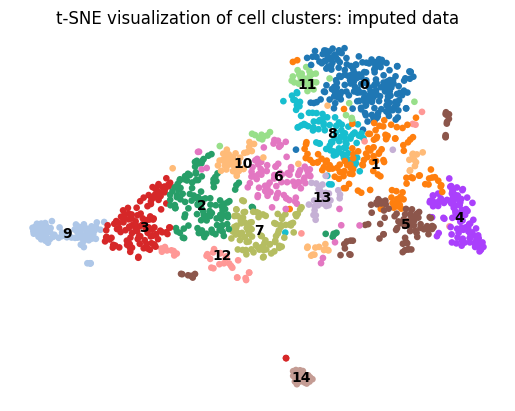

In [307]:
print('X_imputed.shape:',X_imputed.shape)

adata_imp=anndata.AnnData(X=X_imputed, obs=adata.obs, var=adata.var.iloc[genes_to_impute])

sc.tl.pca(adata_imp, svd_solver='arpack')

# Compute the neighborhood graph
sc.pp.neighbors(adata_imp, n_neighbors=5, n_pcs=50)

# Perform Leiden clustering
sc.tl.leiden(adata_imp, resolution=0.6)

# Run t-SNE and visualize the results
tsne = TSNE(n_components=2, random_state=42)
adata_imp.obsm['X_tsne'] = tsne.fit_transform(adata_imp.X)
sc.pl.tsne(adata_imp, color='leiden', legend_loc='on data', title='t-SNE visualization of cell clusters: imputed data', frameon=False)

#### TSNE on imputed data (all of the values)

In [67]:
@torch.no_grad()
def impute_all(model,X):
    model.eval()
    #index_zero=np.where(X==0)
    pred, accs = model(x), []
    X_imputed=X
    X_imputed=pred.cpu().numpy()
    #dropout_pred_train = pred[:len(train)][index_pair_train[0][masking_idx_train], index_pair_train[1][masking_idx_train]]
    #dropout_pred_val=pred[len(train):(len(train)+len(val))][index_pair_val[0][masking_idx_val], index_pair_val[1][masking_idx_val]]
    #dropout_pred_test=pred[-len(test):][index_pair_test[0][masking_idx_test], index_pair_test[1][masking_idx_test]]
    #return dropout_pred_train,dropout_pred_val,dropout_pred_test
    return X_imputed

In [68]:
X_imputed_all=impute_all(model,X)

In [69]:
X_imputed_all.shape

(1301, 4515)

D:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\Anaconda3\envs\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


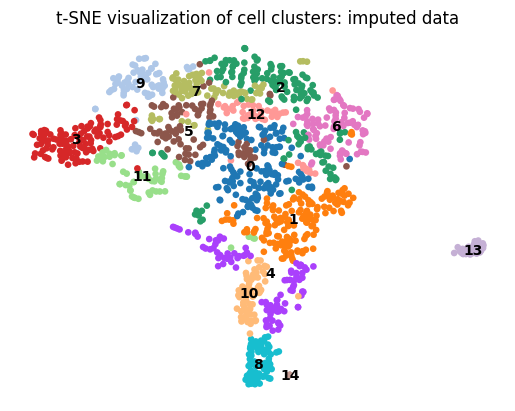

In [70]:
adata_imp_all=anndata.AnnData(X=X_imputed_all, obs=adata.obs, var=adata.var.iloc[genes_to_impute])

sc.tl.pca(adata_imp_all, svd_solver='arpack')

# Compute the neighborhood graph
sc.pp.neighbors(adata_imp_all, n_neighbors=5, n_pcs=50)

# Perform Leiden clustering
sc.tl.leiden(adata_imp_all, resolution=0.6)

# Run t-SNE and visualize the results
tsne = TSNE(n_components=2, random_state=42)
adata_imp_all.obsm['X_tsne'] = tsne.fit_transform(adata_imp_all.X)
sc.pl.tsne(adata_imp_all, color='leiden', legend_loc='on data', title='t-SNE visualization of cell clusters: imputed data', frameon=False)

## Results analysis

In [450]:
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
 
    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

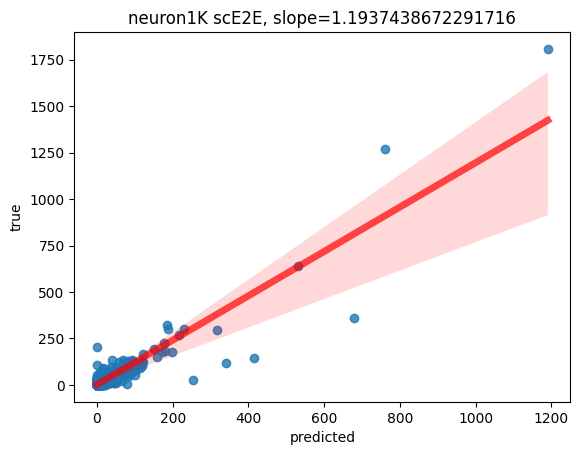

In [451]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

p=sns.regplot(x=dropout_pred.cpu().numpy(), y=np.asarray(dropout_true).reshape(-1,), line_kws={"color":"r","alpha":0.7,"lw":5})
#calculate slope and intercept of regression equation

slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())
plt.title('neuron1K scE2E, slope={}'.format(slope))
plt.xlabel('predicted')
plt.ylabel('true')
plt.savefig('neuron1k_correlation.pdf')